tensor([[-0.6104, -2.2072],
        [-0.5949, -2.1857],
        [-0.3821, -2.1816]], grad_fn=<AddBackward0>)


<Axes: >

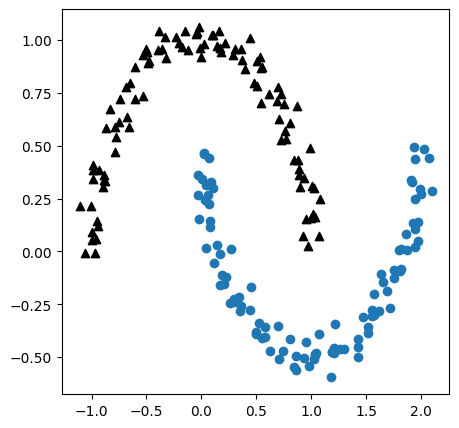

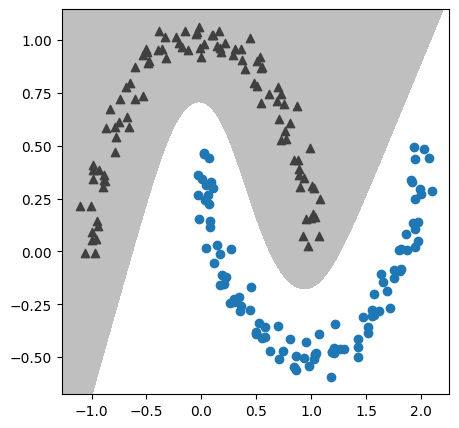

In [13]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt


torch.manual_seed(1024)

#定义线性模型和sigmoid函数
class Linear:
    #input(B,in_features)数据个数，数据特征个数
    #output:(B,out_features)数据个数，输出数据的特征个数
    def __init__(self,in_features,out_features,bias=True):
        #对于模型参数的初始化故意没有做优化
        self.weight=torch.randn(in_features,out_features,requires_grad=True)  #(in_features,out_features)
        if bias:
            self.bias=torch.randn(out_features,requires_grad=True)  #(     ,out_features)
        else:
            self.bias=None

    def __call__(self,x):
        #x:(B,in_features)
        #self.weight:(in_features,out_features)
        self.out=x@self.weight  #(B,out_features)
        if self.bias is not None:
            self.out+=self.bias
        return self.out

    def parameters(self):
        #返回模型参数
        if self.bias is not None:
            return (self.weight, self.bias)
        return [self.weight]

class Sigmoid:
    def __call__(self,x):
        self.out=torch.sigmoid(x)
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self,layers):
        self.layers=layers

    def __call__(self,x):
        for l in self.layers:
            x=l(x)
        self.out=x
        return self.out
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]
    def predict_proba(self,x):
        #计算概率预测
        if isinstance(x,np.ndarray):
            x=torch.tensor(x).float()
        logits=self(x)
        self.prob=F.softmax(logits,dim=-1).detach().numpy()
        return self.prob
#x:[B,2]
#mlp:[4,4,2]
model=Sequential([
    Linear(2,4),Sigmoid(),#(B,4)
    Linear(4,4),Sigmoid(),#(B,4)
    Linear(4,2),#(B,2)
])
x=torch.randn(3,2)
print(model(x))
model.predict_proba(x)
def draw_data(data):
    #将数据可视化
    fig=plt.figure(figsize=(5,5))
    ax=plt.subplot(1,1,1)
    x,y=data
    label1=x[y>0]
    ax.scatter(label1[:,0],label1[:,1],marker='o')
    label0=x[y==0]
    ax.scatter(label0[:,0],label0[:,1],marker='^',color='k')
    return ax
def draw_model(ax,model):
    #将模型的分离超平面可视化
    x1=np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
    x2=np.linspace(ax.get_ylim()[0],ax.get_ylim()[1],100)
    x1,x2=np.meshgrid(x1,x2)
    y=model.predict_proba(np.c_[x1.ravel(),x2.ravel()])[:,1]
    y=y.reshape(x1.shape)
    ax.contourf(x1,x2,y,levels=[0,0.5],colors=['grey'],alpha=0.5)
    return ax

data=make_moons(200,noise=0.05)
draw_data(data)
batch_size=20
max_steps=40000
x,y=torch.tensor(data[0]).float(),torch.tensor(data[1])
learning_rate=0.1
model=Sequential([
    Linear(2,4),Sigmoid(),#(B,4)
    Linear(4,4),Sigmoid(),#(B,4)
    Linear(4,2),#(B,2)
])
lossi=[]
for t in range(max_steps):
    ix=(t*batch_size)%(len(x))
    xx=x[ix:ix+batch_size]
    yy=y[ix:ix+batch_size]
    logits=model(xx)
    loss=F.cross_entropy(logits,yy)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p-=learning_rate*p.grad
            p.grad=None
    lossi.append(loss.item())

ax=draw_data(data)
draw_model(ax,model)

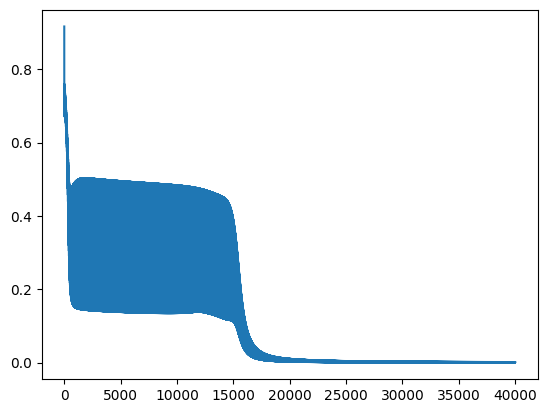

In [17]:
plt.plot(lossi)

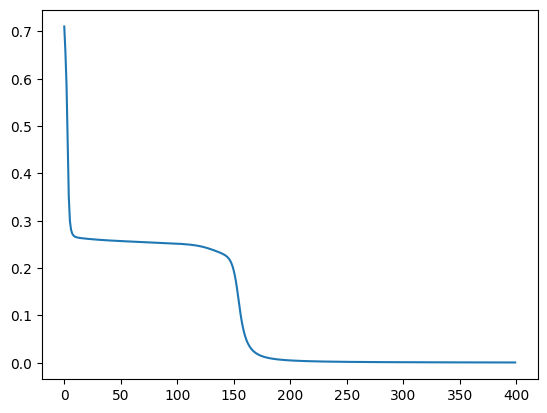

In [16]:
torch.linspace(1,10,10).view(-1,2).mean(dim=1)
plt.plot(torch.tensor(lossi).view(-1,100).mean(dim=-1))